In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
FILEPATH = "/content/cgm_to_meal.csv"
data = (pd.read_csv(FILEPATH, header=0))
data = data.dropna()
train_size = int(len(data) * 0.9)
test_size = len(data) - train_size
train_allData, test_allData = data.iloc[0:train_size], data.iloc[train_size:len(data)]
print(len(train_allData), len(test_allData))

35752 3973


**Idea : CGM (predicted) - CGM (actual) > threshold to be categorized as meal event**

**Part 1 : Finding CGM (predicted)**

In [3]:
cgm_data = train_allData.cgm
# cgm_data_meal = train_allData(train_allData['meal'] == 1)]
cgm_data_no_meal = data[(data['meal'] == 0)]

# cgm_data_meal = cgm_data_meal.cgm
cgm_data_no_meal= cgm_data_no_meal.cgm
# print(cgm_data_no_meal)

In [4]:
train_size_cgm = int(len(cgm_data_no_meal) * 0.8)
test_size_cgm = len(cgm_data_no_meal) - train_size_cgm
train_cgm_no_meal, test_cgm_no_meal = cgm_data_no_meal.iloc[0:train_size_cgm], cgm_data_no_meal.iloc[train_size_cgm:len(cgm_data_no_meal)]
print(len(train_cgm_no_meal), len(test_cgm_no_meal))



31139 7785


In [5]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [6]:
time_steps = 1

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train_cgm_no_meal, train_cgm_no_meal, time_steps)
X_test, y_test = create_dataset(test_cgm_no_meal, test_cgm_no_meal, time_steps)


X_train= X_train.reshape(len(X_train), 1, 1)
X_test= X_test.reshape(len(X_test), 1, 1)


print(X_train.shape, y_train.shape)
# X_test, y_test = create_dataset(test, test.cgm, time_steps)




(31138, 1, 1) (31138,)


In [7]:
model_cgm = keras.Sequential()
model_cgm.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model_cgm.add(keras.layers.Dense(1))
model_cgm.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))
model_cgm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [8]:
history_cgm = model_cgm.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=False
)

Epoch 1/100
876/876 [==============================] - 3s 3ms/step - loss: 15958.9883 - val_loss: 6822.0210
Epoch 2/100
876/876 [==============================] - 2s 2ms/step - loss: 5862.4648 - val_loss: 2538.4690
Epoch 3/100
876/876 [==============================] - 2s 3ms/step - loss: 2841.2180 - val_loss: 1261.9296
Epoch 4/100
876/876 [==============================] - 2s 2ms/step - loss: 1669.7023 - val_loss: 775.6574
Epoch 5/100
876/876 [==============================] - 2s 2ms/step - loss: 1075.2122 - val_loss: 475.4422
Epoch 6/100
876/876 [==============================] - 2s 2ms/step - loss: 725.5750 - val_loss: 347.8013
Epoch 7/100
876/876 [==============================] - 2s 2ms/step - loss: 515.2902 - val_loss: 239.9395
Epoch 8/100
876/876 [==============================] - 2s 2ms/step - loss: 392.0505 - val_loss: 189.9315
Epoch 9/100
876/876 [==============================] - 2s 2ms/step - loss: 315.9643 - val_loss: 152.7097
Epoch 10/100
876/876 [========================

In [9]:
y_pred = model_cgm.predict(X_test)

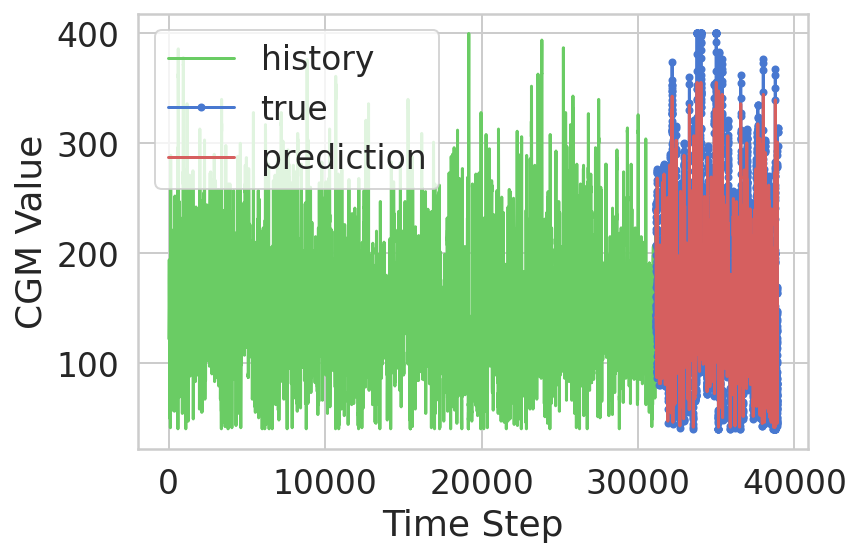

In [10]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('CGM Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

CGM predicted

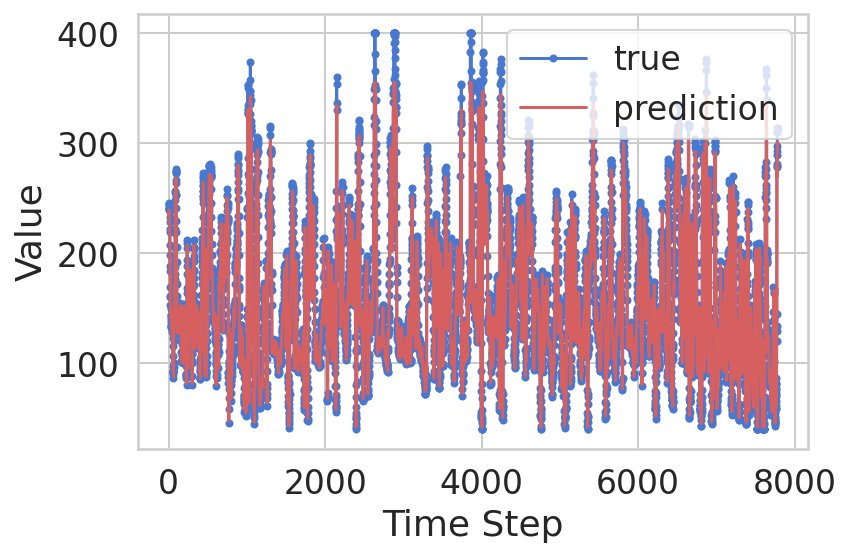

In [11]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

**Part 2: Finding actual CGM**

In [12]:
# print(test_allData)
# print("length of test data :", len(test_allData))

In [13]:
test_allData.meal.value_counts()

0    3888
1      85
Name: meal, dtype: int64

In [14]:
cgm_test = test_allData.cgm
# print(cgm_test)
cgm_test = np.array(cgm_test).reshape(len(cgm_test), 1, 1)
cgm_predicted = model_cgm.predict(cgm_test)
# print(cgm_predicted)
# print(len(cgm_predicted))

Find the corresponding truth (CGM actual)

In [25]:
cgm_actual = cgm_test.tolist()
test_meal_values = test_allData.meal
cgm_actual_flattened = []
for sublist in cgm_actual:
    for item in sublist:
        cgm_actual_flattened.append(item)
# print(cgm_actual_flattened)
# print(test_meal_values)
# print(len(cgm_actual_flattened), len(test_meal_values))


**Part 3: Finding the difference (CGMpredicted - CGMactual)**

In [16]:

cgm_predicted_copy= cgm_predicted.tolist()
print(len(cgm_predicted_copy), len(cgm_actual_flattened))
difference_list=[]
for i in range(len(cgm_predicted)-1):
  difference_list.append(cgm_predicted_copy[i][0]-cgm_actual_flattened[i+1][0])
print(difference_list)


3973 3973
[-1.263671875, -0.241729736328125, -1.198455810546875, -4.1769866943359375, -5.220001220703125, 0.7141571044921875, -7.220001220703125, -3.331085205078125, 4.6457672119140625, -0.198455810546875, 3.844390869140625, -12.0260009765625, -11.241729736328125, -7.45111083984375, -6.58428955078125, -2.702362060546875, -0.702362060546875, 0.358062744140625, -0.5564422607421875, -4.50262451171875, -4.5564422607421875, 0.387237548828125, 0.47076416015625, 6.54888916015625, -3.241729736328125, -5.263671875, 1.668914794921875, -2.241729736328125, -8.241729736328125, 0.622222900390625, -0.3083038330078125, 3.736328125, 1.8657684326171875, -3.048004150390625, -4.069793701171875, 5.8871612548828125, 0.0652923583984375, -2.8863372802734375, -5.910797119140625, -4.0037384033203125, 0.951995849609375, 3.01885986328125, 3.13873291015625, 3.2748641967773438, -0.5662612915039062, -1.5312347412109375, 1.4687652587890625, -0.41878509521484375, -8.378715515136719, -4.6329498291015625, -7.72513580322

In [17]:
test_meal_values= list(test_meal_values)
print(len(test_meal_values))
dic_differece = {}
for m, c in zip(test_meal_values, difference_list):
    dic_differece.setdefault(m, []).append(c)

print(dic_differece)

3973
{0: [-1.263671875, -0.241729736328125, -1.198455810546875, -4.1769866943359375, -5.220001220703125, 0.7141571044921875, -7.220001220703125, -3.331085205078125, 4.6457672119140625, -0.198455810546875, 3.844390869140625, -12.0260009765625, -11.241729736328125, -7.45111083984375, -6.58428955078125, -2.702362060546875, -0.702362060546875, 0.358062744140625, -0.5564422607421875, -4.50262451171875, -4.5564422607421875, 0.387237548828125, 0.47076416015625, 6.54888916015625, -3.241729736328125, -5.263671875, 1.668914794921875, -2.241729736328125, -8.241729736328125, 0.622222900390625, -0.3083038330078125, 3.736328125, 1.8657684326171875, -3.048004150390625, -4.069793701171875, 5.8871612548828125, 0.0652923583984375, -2.8863372802734375, -5.910797119140625, -4.0037384033203125, 0.951995849609375, 3.01885986328125, 3.13873291015625, 3.2748641967773438, -0.5662612915039062, -1.5312347412109375, 1.4687652587890625, -0.41878509521484375, -8.378715515136719, -4.6329498291015625, -7.725135803222

In [ ]:
# Finding difference for no meal values
dic_differece[0]

In [ ]:
# Finding difference for meal values
dic_differece[1]

In [20]:
no_meal_difference = pd.DataFrame({'no_meal':dic_differece[0]})
meal_difference = pd.DataFrame({'meal':dic_differece[1]})

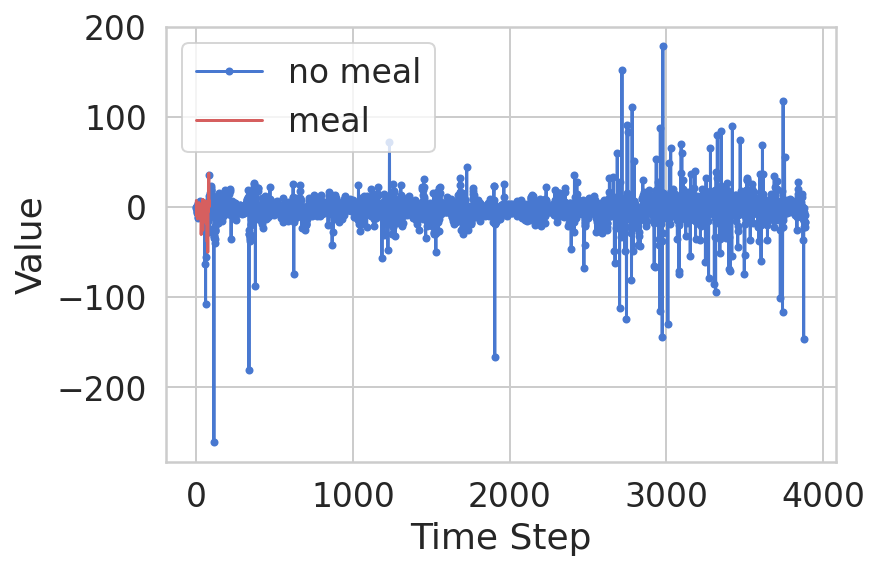

In [21]:
no_meal_rounded = [round(num, 4) for num in dic_differece[0]]

meal_rounded = [round(num, 4) for num in dic_differece[1]]

plt.plot(no_meal_rounded, marker='.', label="no meal")
plt.plot(meal_rounded, 'r', label="meal")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [22]:
# plot_difference = m

In [ ]:
# dict_count_occurences_of_meal = {}

# for val in meal_rounded:
#     if val in dict_count_occurences_of_meal:
#         dict_count_occurences_of_meal[val] += 1
#     else:
#         dict_count_occurences_of_meal[val] = 1

# print(sorted(dict_count_occurences_of_meal.items(), key=lambda x: x[1], reverse=True))

In [ ]:
# dict_count_occurences_of_no_meal = {}

# for val in no_meal_rounded:
#     if val in dict_count_occurences_of_meal:
#         dict_count_occurences_of_no_meal[val] += 1
#     else:
#         dict_count_occurences_of_no_meal[val] = 1

# print(sorted(dict_count_occurences_of_no_meal.items(), key=lambda x: x[1], reverse=True))